# Analysis for the Application of Machine Learning to the EIC Synchrotron Radiation


In [1]:
#Main imports
import sklearn as skl
import pandas as pd
import numpy as np
import ROOT
import os

import keras
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', titlesize=20)
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Welcome to JupyROOT 6.24/04


In [2]:

from load_data import load_data
fname = "data/SR-PHOTONS-LUND-NOFMT-20bun-for-Andrey-NoAU.events.root"; oname = "NoAU testing"
# fname = "data/SR-PHOTONS-LUND-NOFMT-20bun-for-Andrey-AU.events.root"; oname = "AU testing"
(X_train, X_test, y_train, y_test), rdf = load_data(fname, 1, add_cols=True, discard_data=False)

# print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
len(np.unique(np.append(y_test, y_train)))

for c in np.unique(np.append(y_test, y_train)):
    print(c, y_train[y_train == c].shape, y_test[y_test == c ].shape)
# df = pd.DataFrame(np.c_[X_train, y_train], columns = ['vx', 'vy', 'vz', 'px', 'py', 'pz', 'det'])
# df.describe()

# dfs = []
# l = 0
# for h in [50, 150, 250, 350, 450, 550]:
#     dfs.append(df[(l <= df['det']) & (df['det'] < h)].drop(columns="det"))

# dfs[0].describe()
# bins = 200

# fig, axs = plt.subplots(2, 3, figsize=(30,15))
# for i, f in enumerate(dfs):
#     axs = f.hist(bins=bins, histtype='step', ax=axs.flatten()[:6], label="layer "+str(i))
    
# for ax in axs.flatten():
#     ax.set_yscale('log')

# axs[0].legend()
# fig.savefig("imgs/1Dhists_"+oname+".png")

# from pandas.plotting import scatter_matrix

# ax = scatter_matrix(dfs[0], alpha=0.1, figsize=(30,30))
# for f in dfs[1:]:
#     scatter_matrix(f, alpha=0.1, ax=ax)
    
# for ax in axs.flatten():
#     ax.set_yscale('log')


# fig.savefig("imgs/2Dhists_"+oname+".png")


data/SR-PHOTONS-LUND-NOFMT-20bun-for-Andrey-NoAU.events.root { "p", "pphi", "ptheta", "r", "phi", "theta", "x0", "y0", "r0", "phi0", "vx", "vy", "vz", "px", "py", "pz", "ilay", "idet", "ee" } (1843179, 17) (1843179,)
(1843178, 17) (1843178,)
0 (1,) (1803276,)
1 (0,) (2911,)
2 (0,) (7921,)
3 (0,) (7498,)
4 (0,) (9994,)
5 (0,) (11578,)


In [3]:
from joblib import load

forest = load('models/random_forest_090821_1120.model').best_estimator_
adaboost = load('models/adaboost_090821_1122.model').best_estimator_
gradboost = load('models/gradient_boost_090821_1124.model').best_estimator_
# linSVC = load('models/gradient_boost_090821_1116.model').best_estimator_
gausNB = load('models/gaussianNB_090821_1125.model').best_estimator_
knn = load('models/knn_090821_1127.model').best_estimator_
quad = load('models/quad_discrim_090821_1127.model').best_estimator_

dnn = keras.models.load_model('models/DNN_090821_1718.model/')#DNN_090821_1358.model/')#DNN_090821_1346.model/')#DNN_090821_1235.model/')
dnn = keras.models.load_model('models/keras/model_30')#DNN_090821_1718.model/')#DNN_090821_1358.model/')#DNN_090821_1346.model/')#DNN_090821_1235.model/')

clfs = np.array( [  dnn,   forest,          adaboost,   gradboost,        gausNB,         quad])#knn, , linSVC
names = np.array([ 'DNN', 'Random Forest', 'AdaBoost', 'Gradient Boost', 'Naive Bayes',  'Quad Discrim'])#'kNN', , 'Linear SVM'


/tmp/ipykernel_2058806/3245026706.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  clfs = np.array( [  dnn,   forest,          adaboost,   gradboost,        gausNB,         quad])#knn, , linSVC
2021-09-08 20:13:05.170541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-08 20:13:05.494147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4085 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000

In [27]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer, StandardScaler

lb = LabelBinarizer() 
lb.fit(sorted(np.unique(np.append(y_train,y_test))))
y_test_transformed = lb.transform(y_test)

scaler = StandardScaler() 
X_test_transformed = scaler.fit_transform(X_test)
dd = {'ilay_true' : y_test.astype(int)}

for clf, name in zip(clfs, names):
    if name == 'DNN':
        # y_pred_proba = clf.predict_proba(X_test_transformed)
        y_pred_transformed = clf.predict(X_test_transformed)
        y_pred = lb.inverse_transform(y_pred_transformed)
    else:
        # y_pred_proba = clf.predict_proba(X_test)
        y_pred = clf.predict(X_test)

    f1score_macro = f1_score(y_test, y_pred, average='macro')
    f1score_weighted = f1_score(y_test, y_pred, average='weighted')
    auc_score_macro = '--'#roc_auc_score(y_test, y_pred_proba, average="macro")
    auc_score_weighted = '--'#roc_auc_score(y_test, y_pred_proba, average="weighted")
    balancedaccuracyscore = balanced_accuracy_score(y_test, y_pred)
    
    print(f1score_macro, f1score_weighted, auc_score_macro, auc_score_weighted, balancedaccuracyscore, len(np.unique(y_pred)), name)
    print(classification_report(y_test, y_pred, zero_division=1))
    # dd[f'metrics_{name}'] = np.array([f1score_macro, f1score_weighted, auc_score_macro, auc_score_weighted, balancedaccuracyscore, len(np.unique(y_pred))])
    dd[f'ilay_pred_{name}'] = y_pred.astype(int)
    dd[f'ilay_pred_proba_{name}'] = y_pred.astype(int)

for i, col in enumerate(['vx', 'vy', 'vz', 'px', 'py', 'pz', 'ee', 'p', 'pphi', 'ptheta', 'r', 'phi', 'theta', 'x0', 'y0', 'r0', 'phi0']):
    dd[col] = X_test[:, i]


0.05025825483968732 0.25122824541288913 -- -- 0.20144869972244686 6 DNN
              precision    recall  f1-score   support

           0       0.99      0.15      0.26   1803276
           1       0.00      0.80      0.01      2911
           2       0.01      0.03      0.02      7921
           3       0.01      0.09      0.01      7498
           4       0.00      0.00      0.00      9994
           5       0.00      0.14      0.00     11578

    accuracy                           0.15   1843178
   macro avg       0.17      0.20      0.05   1843178
weighted avg       0.96      0.15      0.25   1843178

0.0032434231204531544 0.00010729920561908087 -- -- 0.16548292266049167 5 Random Forest
              precision    recall  f1-score   support

           0       1.00      0.00      0.00   1803276
           1       0.00      0.00      0.00      2911
           2       0.00      0.00      0.00      7921
           3       0.00      0.01      0.01      7498
           4       0.00    

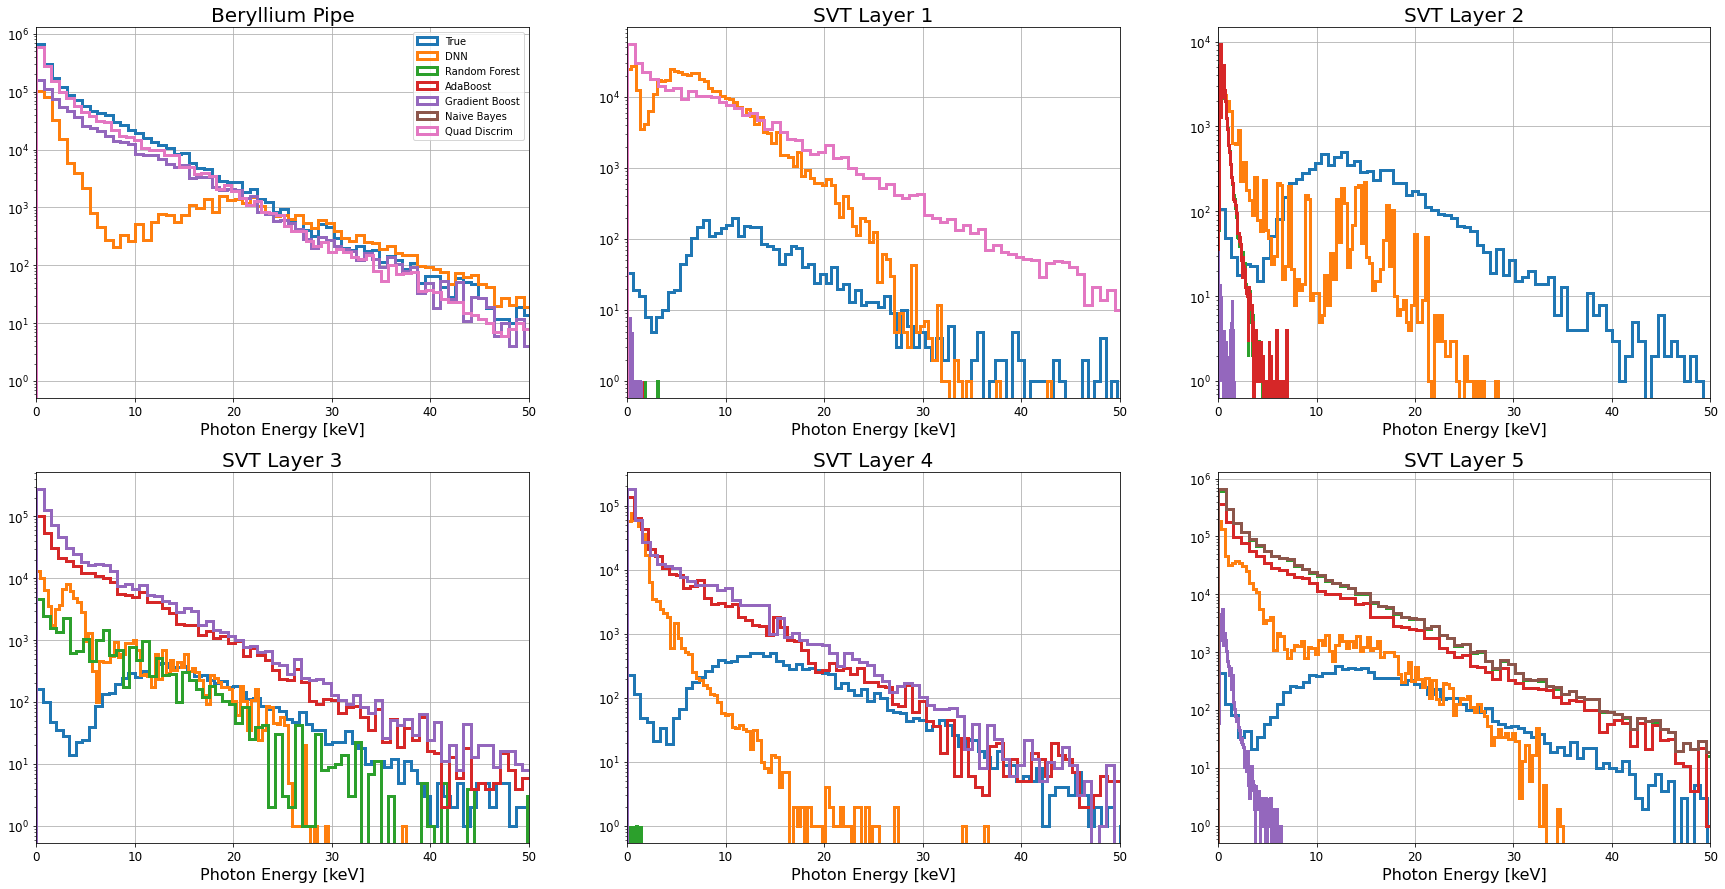

In [25]:
f, axs = plt.subplots(2, 3, figsize=(30,15))
ee = np.array([e*1e6 for e in dd['ee']])
for i, ax in enumerate(axs.flatten()):
    eet = ee[dd['ilay_true'] == i]
    ax.set_yscale('log')
    ax.set_xlabel('Photon Energy [keV]')
    ax.set_xlim(0,50)
    ax.grid()
    ax.set_title(f'SVT Layer {i}' if i else f'Beryllium Pipe')

    bins=100
    t = ax.hist(eet,bins, histtype='step', linewidth=3, label='True')
    for name in names:
        eep = ee[dd[f'ilay_pred_{name}'] == i]
        ax.hist(eep,bins, histtype='step', linewidth=3, label=name)


    if i == 0:
        ax.legend()
    
    

In [6]:


# f, axs = plt.subplots(2, 3, figsize=(30, 15))
# for clf, name, ax in zip(clfs, names, axs.flatten()):
#     if name == 'DNN':
#         y_pred_transformed = clf.predict_proba(X_test_transformed)
#         y_pred = lb.inverse_transform(y_pred_transformed)
#     else:
#         y_pred = clf.predict_proba(X_test)
# clf_scores = np.array([0.]*len(clfs))
# preds = np.zeros((len(clfs), len(y_test)))
# for i, clf in enumerate(clfs):
#     clf = clf.best_estimator_
#     y_pred = clf.predict(X_test)
#     # y_pred_proba = clf.predict_proba(X_test)

#     preds[i] = y_pred
#     f1score = f1_score(y_test, y_pred, average='macro')
#     f1score_lay = f1_score([v//100 for v in y_test], [v//100 for v in y_pred], average='macro')
#     accuracyscore = accuracy_score(y_test, y_pred)
#     balancedaccuracyscore = balanced_accuracy_score(y_test, y_pred)
#     auc_score = '--'#roc_auc_score(y_test, y_pred_proba)
#     clf_scores[i] = f1score

#     print(f1score, f1score_lay, accuracyscore, balancedaccuracyscore, auc_score, len(np.unique(y_pred)), names[i])
